In [1]:
# Library imports
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
import math
%matplotlib inline
from collections import OrderedDict

import umap
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

from arch.VAE import VAE

# The Data

In [2]:
# data settings:
batch_size=128 #input batch size for training (default: 64)
batch_size_test=1000 

# misc settings
no_cuda=False #disables CUDA training (default: True)
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

scale_mu = 0.5
scale_sd = 0.5

# datasets
train_data = datasets.FashionMNIST('../data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((scale_mu,), (scale_sd,))
                    ]))

test_data = datasets.FashionMNIST('../data', train=False, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((scale_mu,), (scale_sd,))
                    ]))

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)

Device: cuda


# Define the VAE

In [3]:
vae = VAE(coarse_resolution=(4,4), hdim=32).to(device)
print("Number of free parameters: ", sum(p.numel() for p in vae.parameters() if p.requires_grad))
batch_ix = 5
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images, _ = batch

    xp, mu, logvar = vae(images.to(device))
    print(images.shape, xp.shape, mu.shape, logvar.shape)
    break

Number of free parameters:  31057
torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128, 32]) torch.Size([128, 32])


# Train

In [18]:
beta=10
optimizer = optim.Adam(vae.parameters(), lr=0.01)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var, beta=1):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='mean')
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE+beta*KLD, BCE, KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        
        recon, mu, log_var = vae(images)
        images = images*scale_sd+scale_mu
        loss, _, _ = loss_function(recon, images, mu, log_var, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(images)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon, mu, log_var = vae(images)
            
            # sum up batch loss
            images = images*scale_sd+scale_mu
            loss, bce, kld = loss_function(recon, images, mu, log_var, beta=beta)
            test_loss += loss.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss

In [19]:
best_test = 10**10
for epoch in range(10):
    train(epoch)
    test_loss = test()

    if test_loss < best_test:
      best_test = test_loss
      torch.save(vae.state_dict(), 'vae.pt')

vae.load_state_dict(torch.load('vae.pt'))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.003821
Train Epoch: 0 [16384/60000 (27%)]	Loss: 0.003800
Train Epoch: 0 [32768/60000 (55%)]	Loss: 0.003887
Train Epoch: 0 [49152/60000 (82%)]	Loss: 0.003885
====> Epoch: 0 Average loss: 0.0038
====> Test set loss: 0.0005
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.003914
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.003769
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.003833
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.003831
====> Epoch: 1 Average loss: 0.0038
====> Test set loss: 0.0005
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003853
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.003880
Train Epoch: 2 [32768/60000 (55%)]	Loss: 0.003856
Train Epoch: 2 [49152/60000 (82%)]	Loss: 0.003788
====> Epoch: 2 Average loss: 0.0038
====> Test set loss: 0.0005
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.003847
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.003845
Train Epoch: 3 [32768/60000 (55%)]	Loss: 0.003780
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.003897
====> Epoch: 3 Average loss:

<All keys matched successfully>

# Save the encoder to drive

In [20]:
torch.save(vae.encoder.state_dict(), '../models/fashion_mnist_encoder_betaten.pt')

# Visualize

In [21]:
batch_ix = 5
vae.eval()
for i, batch in enumerate(train_loader):
  if i==batch_ix:
    images, _ = batch
    with torch.no_grad():
      xp, mu, logvar = vae(images.to(device))
    print(images.shape, xp.shape, mu.shape, logvar.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128, 32]) torch.Size([128, 32])


In [22]:
# Helper function to show batch of images
def show_images(images, nrow=8):
    plt.figure(figsize=(20,20))
    """Show image with landmarks for a batch of samples."""
    num_images = images.shape[0]
    grid_border_size = 1

    grid = utils.make_grid(images, nrow=nrow, padding = grid_border_size, scale_each=True, normalize=True)[0]
    plt.imshow(grid.numpy().transpose((0, 1)))

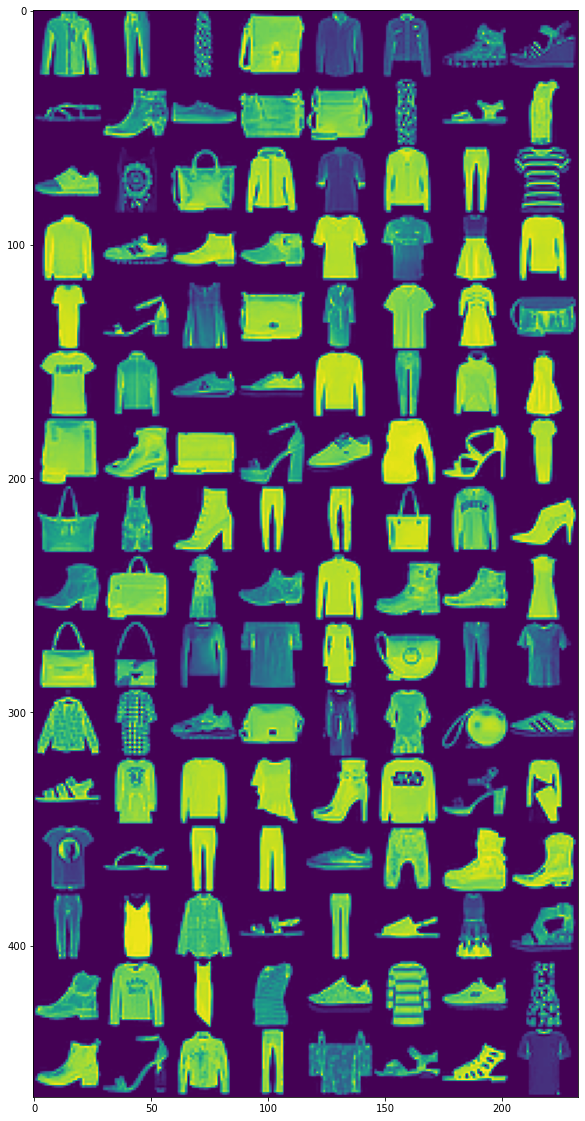

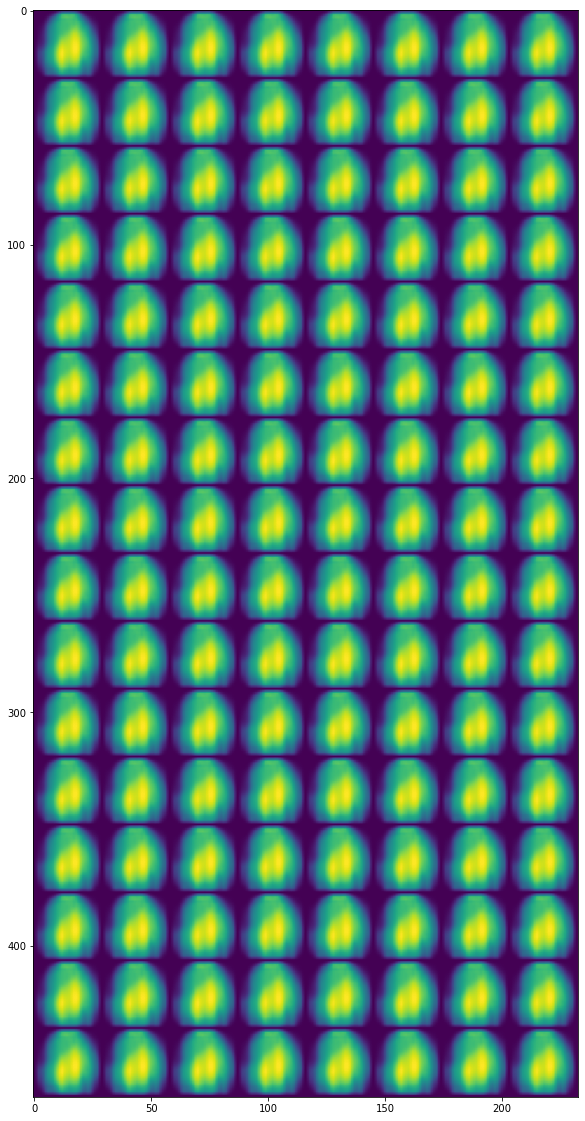

In [23]:
show_images(images.cpu())
show_images(xp.detach().cpu())